In [1]:
import pandas as pd
import numpy as np
import arrow
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor

In [9]:
id = 24
df = pd.read_csv('USvideos.csv')
df_24 = df[df['category_id'] == id]

index = int(len(df_24)*0.8)
df_train =df_24[:index]
df_test = df_24[index:]

X_train = df_train[["likes"]].to_numpy()
Y_train = df_train["views"].to_numpy()
X_test = df_test[["likes"]].to_numpy()
Y_test = df_test["views"].to_numpy()

In [10]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [11]:
Y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print("MSE: %.2f" % mse)
print("R2 Score: %.2f" % r2)



MSE: 8993723439417.94
R2 Score: 0.74


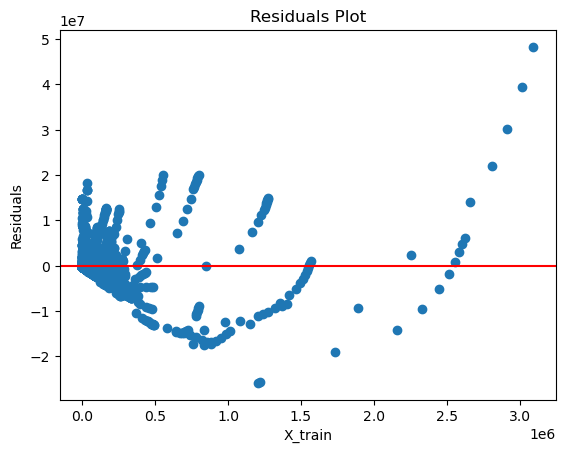

In [12]:
Y_train_pred = model.predict(X_train)

residuals = Y_train - Y_train_pred
studentized_residuals = residuals / np.sqrt(mean_squared_error(Y_train, Y_train_pred))
outliers = np.abs(studentized_residuals) > 2
plt.scatter(X_train, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('X_train')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [13]:
cook_distance = (residuals ** 2) / (model.coef_ ** 2 * X_train.var())
outliers_cooks = cook_distance > 4 / len(X_train[0])

print("Outliers based on studentized residuals:", np.where(outliers)[0])
print("Outliers based on Cook's distance:", np.where(outliers_cooks)[0])

outliers_indices = np.where(outliers)[0]


Outliers based on studentized residuals: [ 141  192  236  245  284  290  301  335  344  354  388  397  446  493
  542  589  641  743  790  838  844  891  897  957 1018 1067 1073 1094
 1128 1133 1146 1166 1193 1196 1198 1245 1255 1300 1312 1345 1364 1373
 1404 1429 1437 1466 1484 1493 1529 1549 1592 1650 1665 1717 1728 1792
 1852 1914 1954 1973 2005 2025 2052 2071 2099 2390 2424 2439 2469 2489
 2516 2539 2562 2589 2604 2650 2702 2979 3036 3085 3136 3182 3323 3380
 3434 3483 3535 3603 3606 3617 3658 3663 3712 3771 3798 3830 3860 3869
 3884 3907 3918 3926 3944 3972 3973 3974 3981 3996 4028 4030 4036 4050
 4077 4083 4119 4126 4140 4165 4171 4182 4207 4214 4236 4260 4288 4334
 4379 4421 4992 5005 5035 5049 5084 5098 5131 5145 5180 5193 5229 5239
 5275 5285 5293 5323 5340 5369 5384 5386 5413 5428 5430 5457 5470 5491
 5492 5513 5528 5548 5549 5569 5571 5584 5593 5604 5605 5623 5641 5647
 5659 5674 5675 5698 5702 5714 5732 5734 5757 5771 5794 5796 5818 5831
 5844 5852 5874 5887 5901 5910 5930 

In [7]:
cleaned_X = np.delete(X_train, outliers_indices, axis=0)
cleaned_y = np.delete(Y_train, outliers_indices, axis=0)

model.fit(cleaned_X, cleaned_y)
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print("new MSE: %.2f" % mse)
print("new R2 Score: %.2f" % r2)

new MSE: 9367065060555.51
new R2 Score: 0.73


In [8]:
outliers_indices_Cook = np.where(outliers_cooks)[0]

cleaned_X_Cook = np.delete(X_train, outliers_indices_Cook, axis=0)
cleaned_y_Cook = np.delete(Y_train, outliers_indices_Cook, axis=0)

model.fit(cleaned_X_Cook, cleaned_y_Cook)
Y_pred_cook = model.predict(X_test)
mse_Cook = mean_squared_error(Y_test, Y_pred_cook)
r2_Cook = r2_score(Y_test, Y_pred_cook)
print("new MSE: %.2f" % mse_Cook)
print("new R2 Score: %.2f" % r2_Cook)

new MSE: 9696949515027.48
new R2 Score: 0.72


In [14]:
all_outliers_indices = np.union1d(outliers_indices, outliers_indices_Cook)

df_10_cleaned = df_24.drop(df_24.index[all_outliers_indices])

df.update(df_10_cleaned)

df = df[df.index.isin(df_10_cleaned.index) & (df['category_id'] == 10)]

df.to_csv(f'USvideos_cleaned_{id}.csv', index=False)

In [15]:
def standardize_trending_date(date_str):
    try:
        date = pd.to_datetime(date_str, format='%y.%d.%m')
        return date.strftime('%Y-%m-%d')
    except ValueError:
        return date_str

def standardize_publish_time(date_str):
    try:
        date = pd.to_datetime(date_str, format='%Y-%m-%d')
        return date.strftime('%Y-%m-%d')
    except ValueError:
        return date_str

In [16]:
df_10_cleaned['trending_date'] = df_10_cleaned['trending_date'].apply(standardize_trending_date)
df_10_cleaned['publish_time'] = df_10_cleaned['publish_time'].apply(standardize_publish_time)

In [17]:

time_series_10 = df_10_cleaned.groupby(['trending_date']).size().reset_index(name = 'counts')
print(time_series_10)

    trending_date  counts
0      2017-11-14      45
1      2017-11-15      45
2      2017-11-16      48
3      2017-11-17      48
4      2017-11-18      47
..            ...     ...
200    2018-06-10      50
201    2018-06-11      50
202    2018-06-12      48
203    2018-06-13      48
204    2018-06-14      47

[205 rows x 2 columns]


In [18]:
iddf = pd.read_csv('US_category_id.csv')

category_dict = pd.Series(iddf.title.values, index=iddf.id).to_dict()

In [19]:
from statsmodels.tsa.arima.model import ARIMA
forecast_results = {}

In [20]:
category_data = time_series_10[:-20]

In [21]:
print(category_data)

    trending_date  counts
0      2017-11-14      45
1      2017-11-15      45
2      2017-11-16      48
3      2017-11-17      48
4      2017-11-18      47
..            ...     ...
180    2018-05-21      56
181    2018-05-22      59
182    2018-05-23      57
183    2018-05-24      59
184    2018-05-25      58

[185 rows x 2 columns]


d:\Anaconda\envs\tensorflow_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


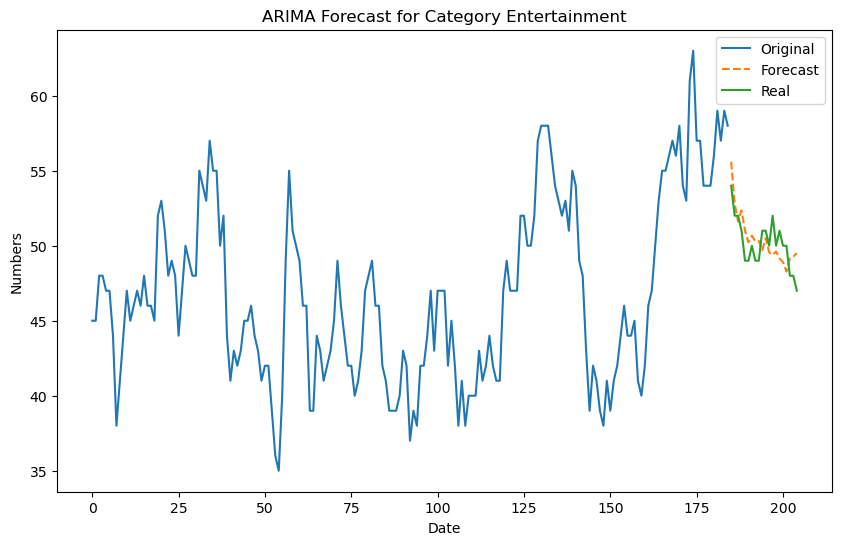

In [50]:
from matplotlib.ticker import MaxNLocator
category_data = time_series_10[:-20]
    

    
ts = category_data['counts']
original_ts = time_series_10['counts'][-20:]
model = ARIMA(ts, order=(20, 1, 3))
model_fit = model.fit()
    
forecast = model_fit.forecast(steps=20)
    
    
plt.figure(figsize=(10, 6))
plt.plot(ts, label='Original')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.plot(original_ts, label='Real')
plt.title(f'ARIMA Forecast for Category {category_dict[id]}')
plt.xlabel('Date')
plt.ylabel('Numbers')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))

plt.legend()
plt.show()